# Energy Portfolio Optimization for Switzerland 2050

This notebook implements a comprehensive energy portfolio optimization framework with three main sections:

1. **Dispatch Simulation** - Full year hourly dispatch of energy production and storage
2. **Genetic Optimizer** - Multi-objective optimization using genetic algorithms
3. **Pareto Frontier Analysis** - 3D Pareto frontier identification and visualization

---


In [6]:
# =============================================================================
# IMPORTS - Run this cell first
# =============================================================================

# Standard library
import os
import sys
import json
import warnings
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D

# Progress tracking
from tqdm.notebook import tqdm

# Interactive widgets
try:
    import ipywidgets as widgets
    from ipywidgets import Dropdown, Button, Output, VBox, HBox, Layout, Label, IntSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False
    print("⚠️ ipywidgets not installed. Run: pip install ipywidgets")

# Suppress warnings
warnings.filterwarnings('ignore')

# Project-specific imports
from config import Config, DEFAULT_CONFIG
from data_loader import load_all_data, CachedData
from ppu_framework import (
    load_all_ppu_data, Portfolio, create_ppu_dictionary,
    estimate_annual_production, check_energy_sovereignty
)
from dispatch_engine import (
    run_dispatch_simulation, initialize_storage_state,
    compute_scenario_cost
)
from optimization import (
    evaluate_portfolio_full_year, Individual,
    run_genetic_algorithm, FullYearResults
)
from portfolio_metrics import (
    PortfolioMetrics3D, calculate_portfolio_metrics_3d
)
from risk_calculator import RiskCalculator
from multi_objective_explorer import (
    MultiObjectiveGA, ObjectiveConfig,
    explore_and_find_frontier, continue_exploration_3d_frontier
)
from pareto_frontier import (
    find_and_plot_efficiency_frontier,
    load_frontier_from_csv,
    plot_efficiency_frontier,
    extract_pareto_frontier_from_df
)
from visualization import (
    plot_fitness_evolution, plot_portfolio_composition,
    plot_dispatch_scenario, create_optimization_dashboard,
    plot_demand_volatility, plot_spot_price_volatility,
    plot_energy_balance_distribution, plot_full_year_overview,
    plot_full_year_storage, plot_full_year_production_by_source
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Create output directories
os.makedirs('data/result_plots', exist_ok=True)

print("✅ All imports successful!")
print(f"   Config loaded: {type(DEFAULT_CONFIG).__name__}")
print(f"   Widgets available: {HAS_WIDGETS}")


✅ All imports successful!
   Config loaded: Config
   Widgets available: True


In [7]:
# =============================================================================
# LOAD DATA - Run after imports
# =============================================================================

print("Loading system data...")
config = DEFAULT_CONFIG
cached_data = load_all_data(config=config, force_reload=True)

# Load PPU definitions (returns tuple: cost_df, constructs_df, ppu_definitions)
cost_df, ppu_df, ppu_definitions = load_all_ppu_data(config=config)
risk_calc = RiskCalculator(config=config)

print(f"\n✅ Data loaded successfully!")
print(f"   Demand data: {len(cached_data.get_demand())} hours")
print(f"   Spot prices: {len(cached_data.get_spot_prices())} hours")
print(f"   PPU types: {len(ppu_definitions)} defined")


Loading system data...
Loading data files...
  - Solar incidence: (9072, 1150)
  - Wind data scaled by 5.0x (mean: 6.7 m/s)
  - Wind incidence: (9072, 1150)
  - Spot prices: (8784,)
  - Demand: (8784,)
  - Hydro data loaded
  - Cost data loaded
  - Aligned all data to 8784 timesteps (366 days)
Data loading complete!

✅ Data loaded successfully!
   Demand data: 8784 hours
   Spot prices: 8784 hours
   PPU types: 26 defined


---

# Section 1: Dispatch Simulation

This section runs a full year (8760 hours) dispatch simulation for a given portfolio.

## Energy System Constraints
- **Annual Electricity Demand:** 59.63 TWh (2050 projection)
- **Aviation Fuel Requirement:** 23 TWh/year biooil (mandatory, auto-imported at 67 CHF/MWh)

## Storage Constraints
| Storage | Base Capacity | Max Cap | RT Efficiency | Notes |
|---------|--------------|---------|---------------|-------|
| Lake | 8.87 TWh (fixed) | - | 77.4% | Physical 2 GW power cap |
| H2 UG 200bar | Scales | **50 TWh** | 30% | |
| Liquid H2 | Scales | **50 TWh** | 35% | |
| CH4 200bar | Scales | **50 TWh** | 39% | |
| Ammonia | Scales | **50 TWh** | 29.25% | |
| Fuel Tank | Scales | **25 TWh** | 35% | |
| Biogas | Scales | **25 TWh** | 49% | |
| Biooil | 500 GWh | - | 30% | Ghost PPU import |
| Palm oil | 500 GWh | - | 30% | Ghost PPU import |

## Utility-Based Dispatch Logic

All storages **self-regulate** around their **target SoC (60%)** using the disposition index:

$$d = \tanh\left(\frac{\text{SoC} - \text{target}}{\text{max\_excursion}}\right)$$

| SoC | Disposition | Behavior |
|-----|-------------|----------|
| 0% | d = -1 | **Wants to charge** |
| 60% | d = 0 | Neutral (at target) |
| 100% | d = +1 | **Wants to discharge** |

### Surplus Distribution (Renewable > Demand)
- **Proportional** to charge willingness × efficiency
- `charge_willingness = max(0, 0.5 - d)` → storages below target get MORE
- No fixed priority order - all storages compete proportionally

### Deficit Coverage (Renewable < Demand)  
- **Cost merit order** with disposition penalty
- `effective_cost = base_cost + penalty(d)` → low SoC storages are "expensive"
- Cheapest sources dispatched first, protecting low storages

### Ghost PPU Mechanism (Biooil & Palm oil)
- Participate in **proportional** surplus distribution (not fixed %)
- Their share is sold on spot market → revenue buys fuel at import price
- Storages self-regulate like all others

---


In [17]:
# =============================================================================
# SECTION 1.1: Define Test Portfolio
# =============================================================================

# Example portfolio for testing (can be modified)
test_portfolio = {
    # Renewable (incidence-based)
    'PV': 500, 'WD_ON': 500, 'WD_OFF': 200, 'HYD_R': 67, 'BIO_WOOD': 300,
    # Storage input
    'PHS': 300, 'H2_G': 100, 'H2_GL': 100, 'H2_L': 200,
    'SYN_FT': 50, 'SYN_CRACK': 50, 'SYN_METH': 200, 'NH3_FULL': 150, 'CH4_BIO': 100,
    # Storage extraction (dispatchable)
    'HYD_S': 200, 'THERM': 150, 'H2P_G': 100, 'H2P_L': 150,
    'THERM_CH4': 300, 'NH3_P': 100, 'IMP_BIOG': 100, 'BIO_OIL_ICE': 200, 'PALM_ICE': 100,
}

print("Test Portfolio Configuration:")
print("=" * 60)
total_units = sum(test_portfolio.values())
print(f"Total PPU units: {total_units}")
renewable = ['PV', 'WD_ON', 'WD_OFF', 'HYD_R', 'BIO_WOOD']
storage_in = ['PHS', 'H2_G', 'H2_GL', 'H2_L', 'SYN_FT', 'SYN_CRACK', 'SYN_METH', 'NH3_FULL', 'CH4_BIO']
storage_out = ['HYD_S', 'THERM', 'H2P_G', 'H2P_L', 'THERM_CH4', 'NH3_P', 'IMP_BIOG', 'BIO_OIL_ICE', 'PALM_ICE']
print(f"  Renewable: {sum(test_portfolio.get(p, 0) for p in renewable)} units")
print(f"  Storage Input: {sum(test_portfolio.get(p, 0) for p in storage_in)} units")
print(f"  Storage Extraction: {sum(test_portfolio.get(p, 0) for p in storage_out)} units")


Test Portfolio Configuration:
Total PPU units: 4217
  Renewable: 1567 units
  Storage Input: 1250 units
  Storage Extraction: 1400 units


In [18]:
# =============================================================================
# SECTION 1.2: Run Full Year Dispatch Simulation
# =============================================================================

print("Running full year dispatch simulation (8760 hours)...")
print("=" * 60)

# Create Portfolio and Individual objects from dictionary
from ppu_framework import Portfolio
from optimization import Individual

test_individual = Individual(
    portfolio=Portfolio(ppu_counts=test_portfolio)
)

# Run full year evaluation
full_year_results = evaluate_portfolio_full_year(
    individual=test_individual,
    config=config,
    verbose=True
)

print("\n" + "=" * 60)
print("DISPATCH SIMULATION RESULTS")
print("=" * 60)

# Energy Balance
total_demand = np.sum(full_year_results.demand) / 1e6
total_production = np.sum(full_year_results.total_production) / 1e6
total_renewable = np.sum(full_year_results.renewable_production) / 1e6
total_bought = np.sum(full_year_results.spot_bought) / 1e6
total_sold = np.sum(full_year_results.spot_sold) / 1e6

print(f"\n📊 Energy Balance:")
print(f"   Total Demand:      {total_demand:>10.2f} TWh")
print(f"   Total Production:  {total_production:>10.2f} TWh")
print(f"   Renewable Only:    {total_renewable:>10.2f} TWh ({100*total_renewable/total_demand:.1f}%)")
print(f"   Spot Bought:       {total_bought:>10.2f} TWh")
print(f"   Spot Sold:         {total_sold:>10.2f} TWh")

# Renewable vs Demand (before storage)
ren = full_year_results.renewable_production
dem = full_year_results.demand
print(f"\n🔍 Renewable vs Demand (before storage):")
print(f"   Gap to fill:       {(np.sum(dem)-np.sum(ren))/1e6:>10.2f} TWh")
print(f"   Hours surplus:     {np.sum(ren > dem):>10} ({100*np.sum(ren>dem)/len(dem):.1f}%)")
print(f"   Hours deficit:     {np.sum(ren < dem):>10} ({100*np.sum(ren<dem)/len(dem):.1f}%)")

# Aviation Fuel
if hasattr(full_year_results, 'aviation_fuel_consumed_mwh'):
    consumed = full_year_results.aviation_fuel_consumed_mwh / 1e6
    import_cost = full_year_results.aviation_fuel_import_cost_chf / 1e9 if hasattr(full_year_results, 'aviation_fuel_import_cost_chf') else 0
    print(f"\n✈️  Aviation Fuel (imported at 67 CHF/MWh):")
    print(f"   Required:          {23.0:>10.2f} TWh/year")
    print(f"   Consumed:          {consumed:>10.2f} TWh")
    print(f"   Import Cost:       {import_cost:>10.2f} B CHF")
    print(f"   Constraint Met:    {'✅ Yes' if full_year_results.aviation_fuel_constraint_met else '❌ No'}")

print("\n" + "=" * 60)


Running full year dispatch simulation (8760 hours)...
FULL YEAR EVALUATION

Loading full year data...
Loading PPU definitions...
Simulating 8784 hours (366 days)...

FULL YEAR RESULTS
Total Demand:     59.6 TWh
Total Production: 59.6 TWh
Coverage Ratio:   100.0%

Spot Market:
  Bought: 0.00 TWh
  Sold:   0.00 TWh
  Net Cost: -0.1 M CHF

Deficit Analysis:
  Hours in deficit: 0 (0.0%)
  Peak deficit: 0 MW

Aviation Fuel (Biooil):
  Required: 23.0 TWh/year
  Consumed: 23.06 TWh (100.3%)
  Shortfall: 0.00 TWh
  Import Cost: 1,545.2 M CHF
  Constraint Met: ✅ YES

DISPATCH SIMULATION RESULTS

📊 Energy Balance:
   Total Demand:           59.63 TWh
   Total Production:       59.63 TWh
   Renewable Only:         18.04 TWh (30.3%)
   Spot Bought:             0.00 TWh
   Spot Sold:               0.00 TWh

🔍 Renewable vs Demand (before storage):
   Gap to fill:            41.59 TWh
   Hours surplus:             24 (0.3%)
   Hours deficit:           8760 (99.7%)

✈️  Aviation Fuel (imported at 67 C

In [19]:
# =============================================================================
# SECTION 1.2b: Incidence vs Demand Analysis (Before Storage)
# =============================================================================

print("=" * 70)
print("INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)")
print("=" * 70)

# Get hourly data
ren = full_year_results.renewable_production  # Incidence-based only
dem = full_year_results.demand
balance = ren - dem  # Positive = surplus, Negative = deficit

# Hourly statistics
surplus_hours = balance > 0
deficit_hours = balance < 0
balanced_hours = balance == 0

surplus_total = np.sum(balance[surplus_hours]) / 1e6  # TWh
deficit_total = -np.sum(balance[deficit_hours]) / 1e6  # TWh (positive value)

print(f"\n📊 HOURLY BREAKDOWN:")
print(f"   Hours with SURPLUS (ren > dem):  {np.sum(surplus_hours):>6} ({100*np.mean(surplus_hours):>5.1f}%)")
print(f"   Hours with DEFICIT (ren < dem):  {np.sum(deficit_hours):>6} ({100*np.mean(deficit_hours):>5.1f}%)")
print(f"   Hours balanced:                  {np.sum(balanced_hours):>6} ({100*np.mean(balanced_hours):>5.1f}%)")

print(f"\n⚡ ENERGY VOLUMES:")
print(f"   Total Incidence (Renewable):     {np.sum(ren)/1e6:>8.2f} TWh")
print(f"   Total Demand:                    {np.sum(dem)/1e6:>8.2f} TWh")
print(f"   -------------------------------------------")
print(f"   Net Gap (Demand - Incidence):    {(np.sum(dem)-np.sum(ren))/1e6:>8.2f} TWh")

print(f"\n🔋 WHAT STORAGE/DISPATCH MUST DO:")
print(f"   Energy from surplus hours:       {surplus_total:>8.2f} TWh (storable)")
print(f"   Energy needed in deficit hours:  {deficit_total:>8.2f} TWh (from storage/dispatch)")

# Peak analysis
peak_surplus = np.max(balance) / 1e3 if np.any(surplus_hours) else 0  # GW
peak_deficit = -np.min(balance) / 1e3 if np.any(deficit_hours) else 0  # GW
mean_deficit = -np.mean(balance[deficit_hours]) / 1e3 if np.any(deficit_hours) else 0  # GW

print(f"\n📈 PEAK ANALYSIS:")
print(f"   Peak Surplus Power:              {peak_surplus:>8.2f} GW")
print(f"   Peak Deficit Power:              {peak_deficit:>8.2f} GW")
print(f"   Mean Deficit (during def hrs):   {mean_deficit:>8.2f} GW")

# Monthly breakdown
print(f"\n📅 MONTHLY BREAKDOWN:")
print("-" * 70)
print(f"{'Month':<10} {'Incidence':<12} {'Demand':<12} {'Balance':<12} {'Status':<15}")
print("-" * 70)

# Assume 2024 (leap year) data
days_per_month = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

start_hour = 0
for month_idx, (days, name) in enumerate(zip(days_per_month, month_names)):
    end_hour = start_hour + days * 24
    if end_hour > len(dem):
        end_hour = len(dem)
    
    month_ren = np.sum(ren[start_hour:end_hour]) / 1e6
    month_dem = np.sum(dem[start_hour:end_hour]) / 1e6
    month_bal = month_ren - month_dem
    status = "✅ SURPLUS" if month_bal > 0 else "⚠️  DEFICIT"
    
    print(f"{name:<10} {month_ren:>10.2f}  {month_dem:>10.2f}  {month_bal:>+10.2f}  {status}")
    start_hour = end_hour

print("-" * 70)
print(f"{'TOTAL':<10} {np.sum(ren)/1e6:>10.2f}  {np.sum(dem)/1e6:>10.2f}  {(np.sum(ren)-np.sum(dem))/1e6:>+10.2f} TWh")
print("=" * 70)


INCIDENCE vs DEMAND ANALYSIS (Before Storage Operations)

📊 HOURLY BREAKDOWN:
   Hours with SURPLUS (ren > dem):      24 (  0.3%)
   Hours with DEFICIT (ren < dem):    8760 ( 99.7%)
   Hours balanced:                       0 (  0.0%)

⚡ ENERGY VOLUMES:
   Total Incidence (Renewable):        18.04 TWh
   Total Demand:                       59.63 TWh
   -------------------------------------------
   Net Gap (Demand - Incidence):       41.59 TWh

🔋 WHAT STORAGE/DISPATCH MUST DO:
   Energy from surplus hours:           0.01 TWh (storable)
   Energy needed in deficit hours:     41.60 TWh (from storage/dispatch)

📈 PEAK ANALYSIS:
   Peak Surplus Power:                  0.62 GW
   Peak Deficit Power:                  9.36 GW
   Mean Deficit (during def hrs):       4.75 GW

📅 MONTHLY BREAKDOWN:
----------------------------------------------------------------------
Month      Incidence    Demand       Balance      Status         
-----------------------------------------------------------------

Saved: data/result_plots/incidence_vs_demand_analysis.png


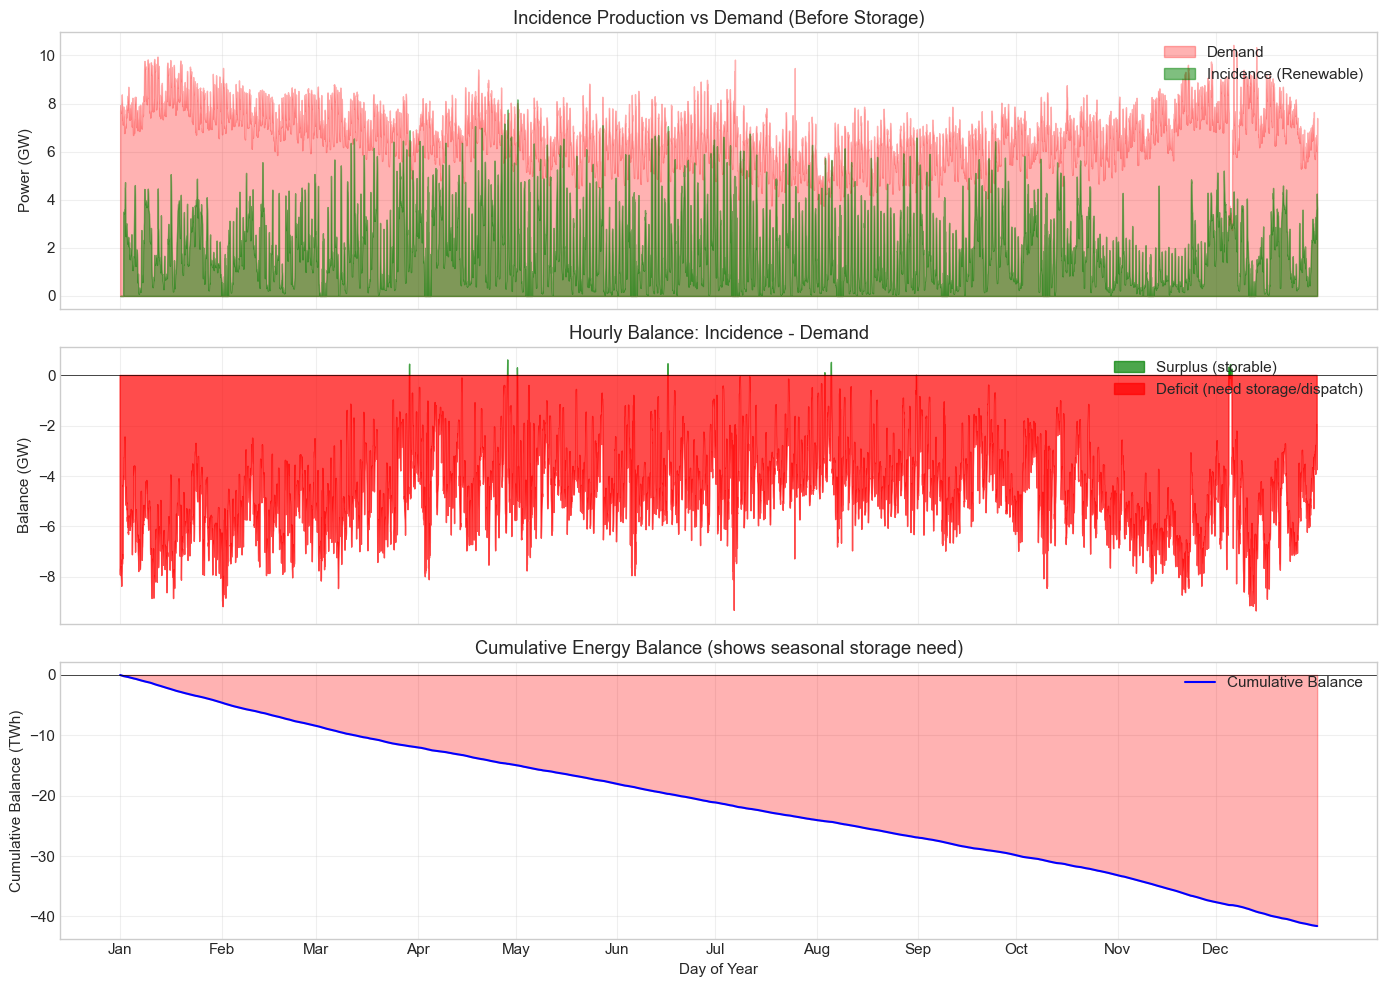


KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.
- Deepest negative point = minimum seasonal storage needed
- In this portfolio: 41.6 TWh seasonal storage required


In [20]:
# =============================================================================
# SECTION 1.2c: Incidence vs Demand Visualization
# =============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Create time axis (days of year)
hours = np.arange(len(dem))
days = hours / 24

# Plot 1: Incidence vs Demand
ax1 = axes[0]
ax1.fill_between(days, dem/1e3, alpha=0.3, label='Demand', color='red')
ax1.fill_between(days, ren/1e3, alpha=0.5, label='Incidence (Renewable)', color='green')
ax1.set_ylabel('Power (GW)')
ax1.set_title('Incidence Production vs Demand (Before Storage)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Balance (Surplus/Deficit)
ax2 = axes[1]
balance_gw = balance / 1e3
ax2.fill_between(days, balance_gw, where=balance_gw >= 0, alpha=0.7, 
                  label='Surplus (storable)', color='green', interpolate=True)
ax2.fill_between(days, balance_gw, where=balance_gw < 0, alpha=0.7, 
                  label='Deficit (need storage/dispatch)', color='red', interpolate=True)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Balance (GW)')
ax2.set_title('Hourly Balance: Incidence - Demand')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Cumulative Energy Balance
ax3 = axes[2]
cumulative_balance = np.cumsum(balance) / 1e6  # TWh cumulative
ax3.plot(days, cumulative_balance, 'b-', linewidth=1.5, label='Cumulative Balance')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance >= 0, 
                  alpha=0.3, color='green')
ax3.fill_between(days, cumulative_balance, where=cumulative_balance < 0, 
                  alpha=0.3, color='red')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Day of Year')
ax3.set_ylabel('Cumulative Balance (TWh)')
ax3.set_title('Cumulative Energy Balance (shows seasonal storage need)')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Add month labels
month_starts = [0, 31, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax3.set_xticks(month_starts)
ax3.set_xticklabels(month_labels)

plt.tight_layout()
plt.savefig('data/result_plots/incidence_vs_demand_analysis.png', dpi=150, bbox_inches='tight')
print("Saved: data/result_plots/incidence_vs_demand_analysis.png")
plt.show()

# Summary annotation
print("\n" + "=" * 70)
print("KEY INSIGHT: The cumulative balance shows the seasonal storage requirement.")
print("- Deepest negative point = minimum seasonal storage needed")
print(f"- In this portfolio: {-np.min(cumulative_balance):.1f} TWh seasonal storage required")
print("=" * 70)


Saved: data/result_plots/dispatch_production_stack.png


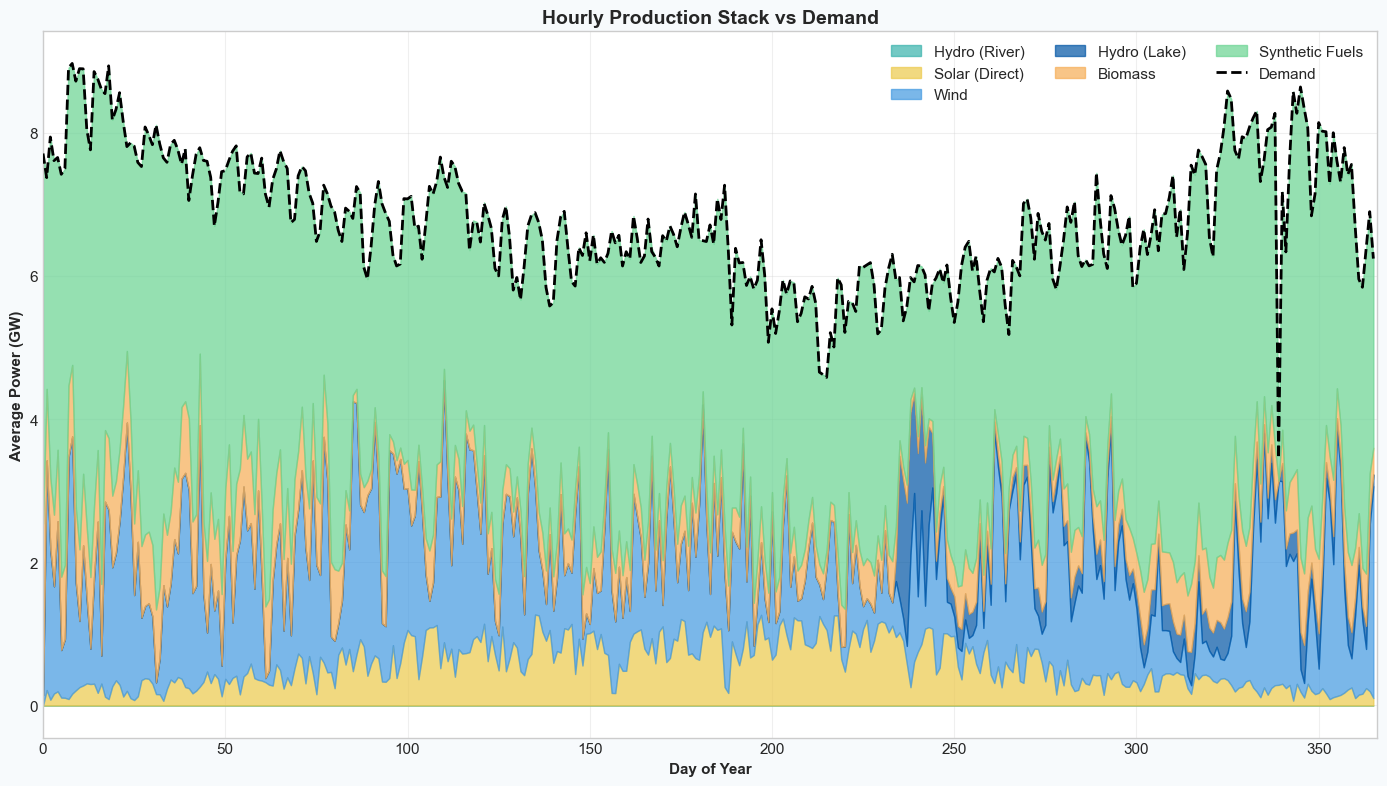

Saved: data/result_plots/dispatch_storage_soc.png


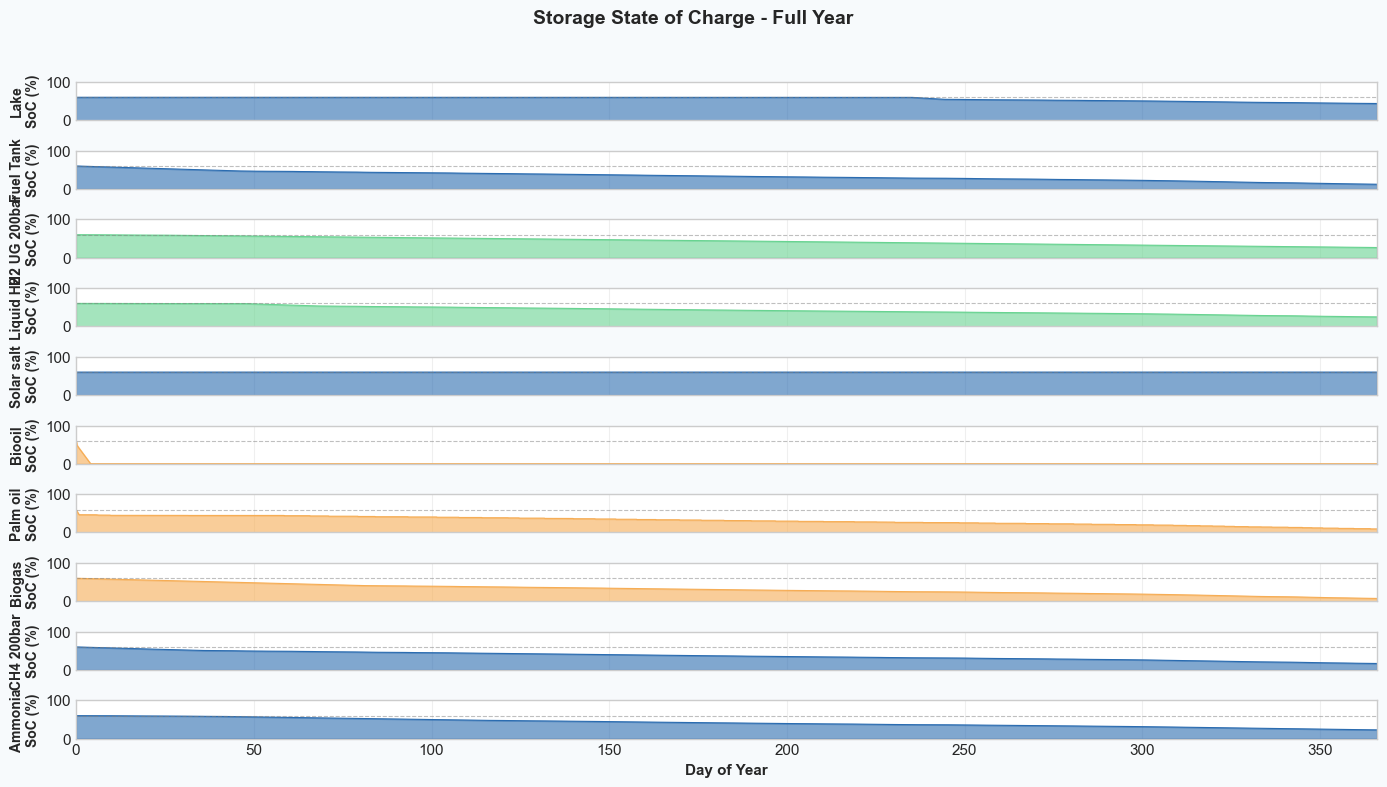

Saved energy balance distribution plot: data/result_plots/dispatch_energy_balance.png


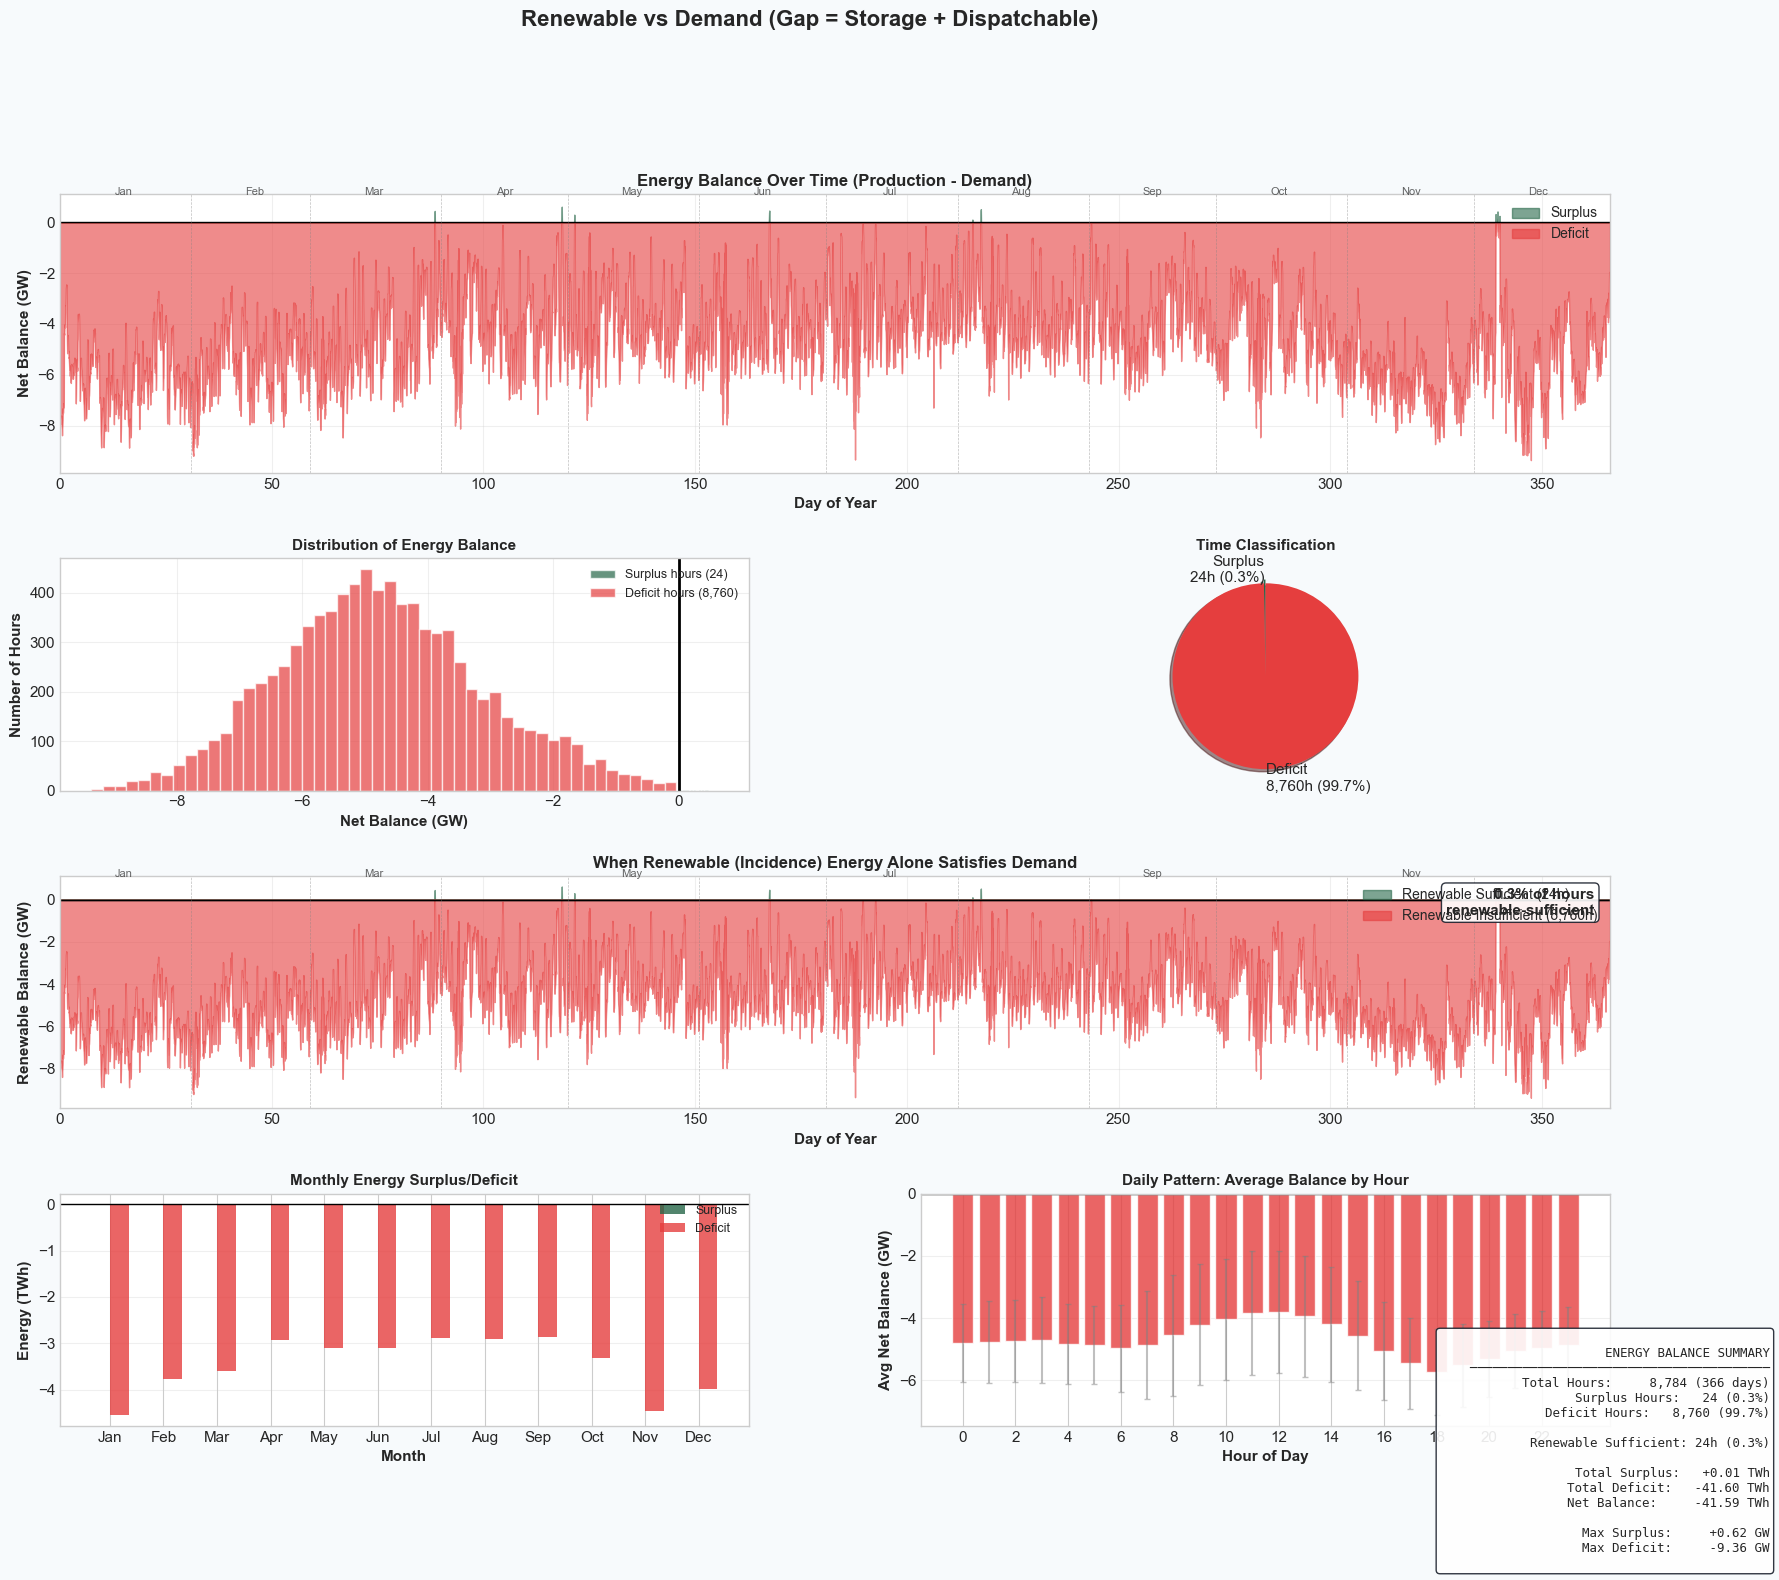

✅ Dispatch visualization complete!


In [21]:
# =============================================================================
# SECTION 1.3: Visualize Dispatch Results
# =============================================================================

# Plot production by source
fig1 = plot_full_year_production_by_source(
    full_year_results,
    title="Hourly Production Stack vs Demand",
    save_path="data/result_plots/dispatch_production_stack.png"
)
plt.show()

# Plot storage state of charge
fig2 = plot_full_year_storage(
    full_year_results,
    title="Storage State of Charge - Full Year",
    save_path="data/result_plots/dispatch_storage_soc.png"
)
plt.show()

# Plot renewable vs demand balance
fig3 = plot_energy_balance_distribution(
    demand=full_year_results.demand,
    production=full_year_results.renewable_production,
    renewable_production=full_year_results.renewable_production,
    title="Renewable vs Demand (Gap = Storage + Dispatchable)",
    save_path="data/result_plots/dispatch_energy_balance.png"
)
plt.show()

print("✅ Dispatch visualization complete!")


---

# Section 2: Genetic Optimizer

This section uses genetic algorithms to find optimal portfolios.

## Constraints

### Portfolio Bounds
Each PPU type has minimum and maximum unit counts defined in `config.ppu.PORTFOLIO_BOUNDS`.

### Progressive Cost Caps
Beyond "soft cap" units, costs increase progressively (economies of scale reversal).

### Genetic Algorithm Parameters
| Parameter | Value | Description |
|-----------|-------|-------------|
| Population | 20-50 | Number of portfolios per generation |
| Generations | 10-50 | Evolution iterations |
| Tournament Size | 3 | Selection pressure |
| Crossover Rate | 0.8 | Offspring generation |
| Mutation Rate | 0.2 | Random exploration |
| Elite Fraction | 0.1 | Top performers preserved |

### Objective Functions
1. **Cost:** Minimize production cost (maximize return)
2. **RoT:** Minimize Risk of Technology (supply chain concentration)
3. **Volatility:** Minimize weekly cost standard deviation

---


In [ ]:
# =============================================================================
# SECTION 2.1: Display Portfolio Bounds
# =============================================================================

print("Portfolio Bounds (PPU unit limits):")
print("=" * 60)

bounds = config.ppu.PORTFOLIO_BOUNDS
print(f"{'PPU':<15} {'Min':>8} {'Max':>8} {'Soft Cap':>10}")
print("-" * 45)

for ppu, (min_val, max_val) in sorted(bounds.items()):
    soft_cap = config.ppu.PROGRESSIVE_COST_CAPS.get(ppu, {}).get('soft_cap', '-')
    print(f"{ppu:<15} {min_val:>8} {max_val:>8} {str(soft_cap):>10}")

print("\n" + "=" * 60)


In [ ]:
# =============================================================================
# SECTION 2.2: Run Multi-Objective Exploration (GA)
# =============================================================================

from multi_objective_explorer import get_objective_configs

print("=" * 60)
print("MULTI-OBJECTIVE GENETIC ALGORITHM")
print("=" * 60)

# Configuration
N_GENERATIONS = 10  # Increase for better coverage
POP_SIZE = 20       # Increase for better diversity
OUTPUT_PATH = "data/result_plots/multi_objective_results.csv"

# Get predefined objectives (cost, rot, volatility, balanced, rot_heavy, vol_heavy)
objectives = get_objective_configs()

print(f"Objectives: {len(objectives)}")
for obj in objectives:
    print(f"  • {obj.name}: {obj.description}")

print(f"\nGenerations per objective: {N_GENERATIONS}")
print(f"Population size: {POP_SIZE}")
print(f"Output: {OUTPUT_PATH}")
print("\n" + "=" * 60)


In [ ]:
# =============================================================================
# SECTION 2.3: Execute Multi-Objective GA
# =============================================================================

# Run exploration (this can take 30-60 minutes)
all_results_df, pareto_df = explore_and_find_frontier(
    config=config,
    objectives=objectives,
    n_generations=N_GENERATIONS,
    pop_size=POP_SIZE,
    output_path=OUTPUT_PATH,
    verbose=True,
    use_existing_as_seeds=True
)

print("\n" + "=" * 60)
print(f"✅ Exploration complete!")
print(f"   Total portfolios: {len(all_results_df)}")
print(f"   Frontier portfolios: {len(pareto_df)}")


---

# Section 3: Pareto Frontier Analysis

This section identifies the 3D Pareto frontier and analyzes frontier portfolios.

## Constraints

### Pareto Dominance
Portfolio A dominates Portfolio B if:
- A is at least as good as B in all objectives
- A is strictly better than B in at least one objective

The Pareto frontier contains all non-dominated portfolios.

### 3D Metrics Definitions
| Metric | Definition | Optimization Goal |
|--------|------------|-------------------|
| **RoT** | Risk of Technology - supply chain concentration (0-1) | Minimize |
| **Volatility** | Weekly std of production costs (CHF/MWh) | Minimize |
| **Return** | (spot_price - production_cost) / spot_price × 100% | Maximize |

---


In [ ]:
# =============================================================================
# SECTION 3.1: Find 3D Pareto Frontier
# =============================================================================

def find_3d_pareto_frontier(df: pd.DataFrame) -> pd.DataFrame:
    """
    Find 3D Pareto frontier: minimize RoT, minimize volatility, maximize return.
    """
    rot = df['x_RoT'].values
    vol = df['y_volatility'].values
    ret = -df['z_return'].values  # Negate because we maximize return
    
    n = len(df)
    is_dominated = np.zeros(n, dtype=bool)
    
    for i in range(n):
        if is_dominated[i]:
            continue
        for j in range(n):
            if i == j or is_dominated[j]:
                continue
            # Check if j dominates i
            if (rot[j] <= rot[i] and vol[j] <= vol[i] and ret[j] <= ret[i] and
                (rot[j] < rot[i] or vol[j] < vol[i] or ret[j] < ret[i])):
                is_dominated[i] = True
                break
    
    return df[~is_dominated].copy()

# Load results if not in memory
if 'all_results_df' not in dir() or all_results_df is None:
    all_results_df = pd.read_csv(OUTPUT_PATH)

# Find 3D frontier
frontier_3d = find_3d_pareto_frontier(all_results_df)

print(f"3D Pareto Frontier: {len(frontier_3d)} portfolios")
print(f"\nFrontier ranges:")
print(f"  RoT: [{frontier_3d['x_RoT'].min():.4f}, {frontier_3d['x_RoT'].max():.4f}]")
print(f"  Volatility: [{frontier_3d['y_volatility'].min():.2f}, {frontier_3d['y_volatility'].max():.2f}]")
print(f"  Return: [{frontier_3d['z_return'].min():.2f}%, {frontier_3d['z_return'].max():.2f}%]")

# Save frontier
frontier_path = "data/result_plots/multi_objective_results_final_frontier_3d.csv"
frontier_3d.to_csv(frontier_path, index=False)
print(f"\nFrontier saved to: {frontier_path}")


In [ ]:
# =============================================================================
# SECTION 3.2: Visualize 3D Pareto Frontier
# =============================================================================

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot all portfolios
ax.scatter(
    all_results_df['x_RoT'], all_results_df['y_volatility'], all_results_df['z_return'],
    c='lightgray', alpha=0.3, s=20, label='All portfolios'
)

# Plot frontier
scatter = ax.scatter(
    frontier_3d['x_RoT'], frontier_3d['y_volatility'], frontier_3d['z_return'],
    c=frontier_3d['z_return'], cmap='viridis',
    s=100, edgecolors='black', linewidth=1, label='Pareto Frontier'
)

# Highlight extreme points
best_return = frontier_3d.loc[frontier_3d['z_return'].idxmax()]
best_rot = frontier_3d.loc[frontier_3d['x_RoT'].idxmin()]
best_vol = frontier_3d.loc[frontier_3d['y_volatility'].idxmin()]

ax.scatter([best_return['x_RoT']], [best_return['y_volatility']], [best_return['z_return']],
          c='green', s=300, marker='*', edgecolors='black', linewidth=2, label='Best Return')
ax.scatter([best_rot['x_RoT']], [best_rot['y_volatility']], [best_rot['z_return']],
          c='blue', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest RoT')
ax.scatter([best_vol['x_RoT']], [best_vol['y_volatility']], [best_vol['z_return']],
          c='red', s=300, marker='*', edgecolors='black', linewidth=2, label='Lowest Vol')

ax.set_xlabel('Risk of Technology (RoT)', fontsize=12, fontweight='bold')
ax.set_ylabel('Volatility (CHF/MWh)', fontsize=12, fontweight='bold')
ax.set_zlabel('Return (%)', fontsize=12, fontweight='bold')
ax.set_title('3D Pareto Frontier: RoT vs Volatility vs Return', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Return (%)', shrink=0.6)
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('data/result_plots/pareto_frontier_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 3D Pareto frontier visualization saved!")


In [ ]:
# =============================================================================
# SECTION 3.3: Analyze Frontier Portfolios
# =============================================================================

print("=" * 60)
print("PARETO FRONTIER PORTFOLIOS")
print("=" * 60)

for idx, (_, row) in enumerate(frontier_3d.iterrows()):
    print(f"\nPortfolio #{idx+1}:")
    print(f"  RoT:        {row['x_RoT']:.4f}")
    print(f"  Volatility: {row['y_volatility']:.2f} CHF/MWh")
    print(f"  Return:     {row['z_return']:.2f}%")
    
    # Parse portfolio
    pf_dict = json.loads(row['portfolio_dict']) if isinstance(row['portfolio_dict'], str) else row['portfolio_dict']
    top_ppus = sorted(pf_dict.items(), key=lambda x: -x[1])[:5]
    print(f"  Top PPUs: {', '.join(f'{p}:{c}' for p, c in top_ppus)}")

print("\n" + "=" * 60)


---

## Summary

This notebook provides a complete framework for:

1. **Dispatch Simulation:** Full year hourly simulation with storage management
2. **Genetic Optimization:** Multi-objective portfolio optimization
3. **Pareto Analysis:** 3D frontier identification and visualization

### Key Features
- Storage capacity caps (50 TWh for H2/CH4/NH3, 25 TWh for Fuel/Biogas)
- Ghost PPU mechanism for biooil/palm oil import regulation
- Aviation fuel hard constraint (23 TWh/year)
- 3D Pareto frontier (RoT, Volatility, Return)

### Output Files
- `data/result_plots/multi_objective_results.csv` - All evaluated portfolios
- `data/result_plots/multi_objective_results_final_frontier_3d.csv` - Pareto frontier
- Various PNG visualizations
